In [24]:
%matplotlib inline



import pandas as pd
import requests
import re
import ast
import numpy as np
import seaborn as sns

from collections import defaultdict


In [25]:
ccc_df = pd.read_csv("data/ccc_blm.csv")
ele_df = pd.read_csv("data/ele.csv")
cl_df = pd.read_csv("data/cl_blm.csv")
wiki_df = pd.read_csv("data/wiki_blm.csv")


dfs = [ccc_df, ele_df, cl_df, wiki_df]

In [26]:
df = pd.concat(dfs).reset_index(drop=True)
len(df)

5247

In [27]:
date_start = pd.to_datetime('2020-05-25')
df = df[pd.to_datetime(df['date']) >= date_start].copy()




In [28]:
df['date'] = pd.to_datetime(df['date'])
df['date'].value_counts()

2020-05-30    793
2020-05-31    785
2020-06-01    454
2020-06-02    392
2020-06-06    371
2020-06-03    341
2020-05-29    319
2020-06-05    299
2020-06-07    267
2020-06-04    226
2020-05-28    113
2020-06-08     94
2020-06-09     62
2020-06-10     39
2020-05-27     28
2020-05-26     16
2020-06-11      9
2031-05-30      2
2020-06-14      2
2030-05-29      1
2040-06-01      1
2020-05-25      1
2020-06-12      1
2020-06-13      1
2020-06-20      1
Name: date, dtype: int64

In [29]:
# fix stay commas

df['city_st'] = df['city_st'].str.replace(' , ', ', ')
df['city_st'] = df['city_st'].str.strip()


len(df)

4618

In [30]:
# eliminate non US events

countries = [
    "Finland",
    "England",
    "Wales",
    "Canada",
    "Scotland",
    "Germany",
    "Ireland", 'Sweden'
    "Netherlands",
    "New Zealand",
    "Denmark",
    "Australia",
    "Belgium",
    "France", 'Hungary',
]


def in_us(city_st):
    for c in countries:
        c2 = ", " + c
        if c2 in city_st:
            return False

    return True


df = df[df["city_st"].apply(in_us)].copy()
len(df)

4569

In [31]:
errors = {'Albuqeurque, NM' : 'Albuquerque, NM',
         'Bilings, MT' : 'Billings, MT',
         'Breckinridge, CO' : 'Breckinridge, CO',
          "Longbranch, NJ" : "Long Branch, NJ",
          'Lousiville, KY' : 'Louisville, KY',
          'Merrick, New York' : 'Merrick, NY',
          'Pittsfield Charter Township, MI' : 'Pittsfield, MI',
          'Pittsfield Township, MI' : 'Pittsfield, MI',
          'Phillipsburg, PA' : 'Philipsburg, PA',
          'South Sacramento, CA' :  'Sacramento, CA',
          'Shelbourne Falls, MA' : 'Shelburne Falls, MA',
          'Tallahasee, FL' : 'Tallahassee, FL',
          'Tampa Bay, FL' : "Tampa, Fl",
          'Voorhees Township, NJ' : 'Voorhees, NJ',
          'Warren Township, NJ' : 'Warren, NJ', 
          'Summerlin, NV' : 'Las Vegas, NV',
          'Stockton, TX' : 'Fort Stockton, TX',
          'Standford, CA' : 'Stanford, CA',
        
          
         }

for city in errors:
    df['city_st'] = df['city_st'].str.replace(city, errors[city])

In [32]:
#uniform saint to st
df['city_st'] = df['city_st'].str.replace('Saint ', 'St. ')

In [33]:
df['events'] = 1
df['size'] = df['size'].replace(0,np.nan)
df['size_imp'] = df['size'].fillna(11)


df = pd.concat([df, pd.get_dummies(df['collection'])], axis=1)

In [34]:
pd.to_datetime(df['date']).value_counts().head(30)

2020-05-30    790
2020-05-31    775
2020-06-01    449
2020-06-02    389
2020-06-06    369
2020-06-03    337
2020-05-29    319
2020-06-05    294
2020-06-07    255
2020-06-04    223
2020-05-28    113
2020-06-08     93
2020-06-09     61
2020-06-10     39
2020-05-27     28
2020-05-26     16
2020-06-11      9
2031-05-30      2
2020-06-14      2
2030-05-29      1
2040-06-01      1
2020-05-25      1
2020-06-12      1
2020-06-13      1
2020-06-20      1
Name: date, dtype: int64

In [35]:
# extract urls to make them variables

def str_2_list(links):
    return ast.literal_eval(links)

df['url_list'] = df['urls'].apply(str_2_list)


urls = set([item for sublist in df['url_list'].values for item in sublist])

for url in urls:
    df[url] = df['urls'].str.contains(url)

/Users/nealcaren/opt/anaconda3/envs/tmwp/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


First Pass at Aggregation

In [36]:
# first sum by collection for multiple events by city
df_cd = df.groupby(['collection', 'date', 'city_st']).sum().reset_index()

In [37]:
df_cd['size_imp'] = df_cd['size'].fillna(11)



In [38]:
for v in ["CCC", 
    "Count Love", 
    "Elephrame",
         "Wikipedia"]:
    df_cd[v] = df_cd[v] > 0
    df_cd[v] = df_cd[v].astype(int)

In [39]:

aggregation = {
    "events": "max",
    "size": "max",
    "size_imp" : "max",
    "CCC" : "max",
    "Wikipedia" : "max",
    "Count Love" : "max",
    "Elephrame" : "max"
}


for url in urls:
    aggregation[url] = 'max'

df_cd = df_cd.groupby(["date", "city_st"]).agg(aggregation).reset_index()

In [40]:
# Create list of URLs

index_dict = defaultdict(list)

http_urls = [u for u in df_cd.keys() if 'http' in u]

for url in http_urls:
    for i in df_cd[df_cd[url] == True].index.values:
        index_dict[i].append(url)

url_df = pd.Series(index_dict).to_frame(name='urls')



In [41]:
keep = [
    "date",
    "city_st",
    "events",
    "size",
    "size_imp",
    "CCC",
    "Count Love",
    "Elephrame",
    "Wikipedia"

]

In [42]:
df_cd = df_cd[keep].merge(url_df, left_index=True, right_index=True)

In [43]:
df_cd['size'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [44]:
date_start = pd.to_datetime('2020-05-24')
df_cd = df_cd[pd.to_datetime(df_cd['date']) >= date_start].copy()



In [45]:
# remove future events
df_cd = df_cd[pd.to_datetime(df_cd['date']) < pd.Timestamp.today()].copy()
df_cd.reset_index(inplace=True)


In [46]:


df_cd.to_csv('../BLM-GFAABT.csv', index =False)




In [47]:
temp = df_cd.groupby(['date','city_st']).agg({'events': 'count',
                                            'Elephrame' : 'max',
                                            'CCC': 'max',
                                            'Count Love': 'max',
                                             'Wikipedia' : 'max'}).reset_index()

temp['cities'] = temp['events']
print(temp.groupby('date')[['cities','Elephrame','CCC','Count Love', 'Wikipedia']].sum().to_markdown())

| date                |   cities |   Elephrame |   CCC |   Count Love |   Wikipedia |
|:--------------------|---------:|------------:|------:|-------------:|------------:|
| 2020-05-25 00:00:00 |        1 |           0 |     0 |            0 |           1 |
| 2020-05-26 00:00:00 |        9 |           3 |     4 |            7 |           0 |
| 2020-05-27 00:00:00 |       14 |           6 |     9 |           11 |           0 |
| 2020-05-28 00:00:00 |       50 |          10 |    35 |           41 |          13 |
| 2020-05-29 00:00:00 |      158 |          33 |    99 |          121 |          44 |
| 2020-05-30 00:00:00 |      388 |          69 |   173 |          308 |         173 |
| 2020-05-31 00:00:00 |      462 |          86 |   171 |          312 |         167 |
| 2020-06-01 00:00:00 |      310 |          36 |   133 |          147 |         103 |
| 2020-06-02 00:00:00 |      276 |          35 |   147 |           96 |          65 |
| 2020-06-03 00:00:00 |      244 |          64 |   108

In [48]:
print(df_cd.groupby('date')['events'].sum().to_markdown())

| date                |   events |
|:--------------------|---------:|
| 2020-05-25 00:00:00 |        1 |
| 2020-05-26 00:00:00 |       10 |
| 2020-05-27 00:00:00 |       16 |
| 2020-05-28 00:00:00 |       59 |
| 2020-05-29 00:00:00 |      176 |
| 2020-05-30 00:00:00 |      438 |
| 2020-05-31 00:00:00 |      486 |
| 2020-06-01 00:00:00 |      330 |
| 2020-06-02 00:00:00 |      307 |
| 2020-06-03 00:00:00 |      268 |
| 2020-06-04 00:00:00 |      192 |
| 2020-06-05 00:00:00 |      231 |
| 2020-06-06 00:00:00 |      283 |
| 2020-06-07 00:00:00 |      205 |
| 2020-06-08 00:00:00 |       81 |
| 2020-06-09 00:00:00 |       54 |
| 2020-06-10 00:00:00 |       36 |
| 2020-06-11 00:00:00 |        9 |
| 2020-06-12 00:00:00 |        1 |


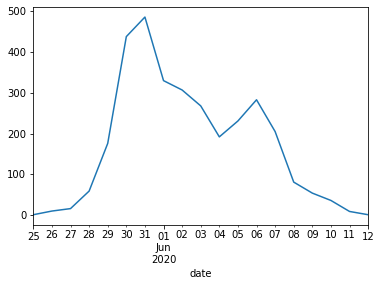

In [49]:
df_cd.groupby('date')['events'].sum().plot();

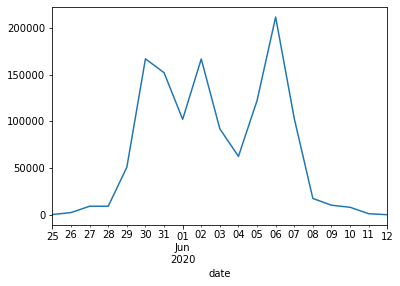

In [50]:
df_cd.groupby('date')['size_imp'].sum().plot();

In [51]:
df_cd['size_imp'].count()

2853

In [52]:
df_cd['size_imp'].sum()

1287266.65

In [53]:


df_cd['size'].describe()

count     1841.000000
mean       693.174715
std       3313.365570
min          1.000000
25%        100.000000
50%        200.000000
75%        400.000000
max      95500.000000
Name: size, dtype: float64

In [54]:
df_cd.groupby(["CCC", "Count Love", 'Elephrame','Wikipedia'])['events'].count().reset_index()

,CCC,Count Love,Elephrame,Wikipedia,events
0,0,0,0,1,414
1,0,0,1,0,253
2,0,0,1,1,15
3,0,1,0,0,781
4,0,1,0,1,120
5,0,1,1,0,96
6,0,1,1,1,18
7,1,0,0,0,521
8,1,0,0,1,58
9,1,0,1,0,47


In [55]:
df.sort_values('city_st').head(10)

,id,date,city_st,location,size,size_str,urls,collection,Unnamed: 0,events,...,https://www.sfgate.com/news/slideshow/Simone-Jacques-Mission-District-protest-203235.php,https://twitter.com/bryanevans247/status/1267602852332986368,https://www.npr.org/sections/health-shots/2020/06/10/873375919/street-medics-fight-covid-19-and-tend-to-protesters-wounds,https://helenair.com/news/local/demonstrators-gather-in-helena-to-protest-the-killing-of-george-floyd/article_c43c84f3-0710-514f-abda-ccd528c07e7c.html,https://journalstar.com/news/local/watch-now-thousands-gather-for-peaceful-rally-outside-capitol/article_5217a9af-5018-5a04-84ef-0645e4c1dbcd.html,https://www.wgrz.com/article/news/crime/protester-tries-to-set-buffalo-city-hall-on-fire/71-557ea29e-a40a-4da3-a5a4-f4726589010c,https://twitter.com/MelissaLaverty/status/1268364389087948803,https://twitter.com/WendyBredhold/status/1267584411677097984,https://www.thetimesherald.com/story/news/2020/05/30/local-residents-protest-death-george-floyd-pine-grove-park/5292067002/,https://www.courierpress.com/story/news/local/2020/06/07/evansville-protest-gives-voice-passions-and-does-peacefully-police-brutality/3162153001/
3188,31515.0,2020-05-30,"Abilene, TX","Abilene, TX",150.0,150,['https://www.reporternews.com/story/news/loca...,Count Love,NaN,1,...,False,False,False,False,False,False,False,False,False,False
5110,NaN,2020-05-31,"Abilene, TX",NaN,24.0,Dozens,['https://www.bigcountryhomepage.com/news/doze...,Wikipedia,866.0,1,...,False,False,False,False,False,False,False,False,False,False
4167,31334.0,2020-06-07,"Abilene, TX","Abilene Christian University, Abilene, TX",NaN,NaN,['https://www.reporternews.com/story/news/2020...,Count Love,NaN,1,...,False,False,False,False,False,False,False,False,False,False
5172,NaN,2020-06-06,"Abingdon, VA",NaN,NaN,NaN,['https://www.heraldcourier.com/gallery/abingd...,Wikipedia,930.0,1,...,False,False,False,False,False,False,False,False,False,False
5193,NaN,2020-06-06,"Accomac, VA",NaN,200.0,hundreds,['https://shoredailynews.com/headlines/eastern...,Wikipedia,952.0,1,...,False,False,False,False,False,False,False,False,False,False
3927,30768.0,2020-06-05,"Ada, OK","Ada, OK",1000.0,1000,['https://www.theadanews.com/news/local_news/1...,Count Love,NaN,1,...,False,False,False,False,False,False,False,False,False,False
1289,NaN,2020-06-07,"Adrian, MI","downtown, Adrian, MI",400.0,abou 400,['https://www.lenconnect.com/news/20200608/uni...,CCC,NaN,1,...,False,False,False,False,False,False,False,False,False,False
1553,NaN,2020-06-07,"Adrian, MI","Adrian, MI",400.0,400 demonstrators,['https://www.hollandsentinel.com/news/2020060...,Elephrame,NaN,1,...,False,False,False,False,False,False,False,False,False,False
1472,3730.0,2020-06-10,"Agawam, MA","Agawam, MA",75.0,75-100 (est.) demonstrators,['https://www.wwlp.com/news/local-news/hampden...,Elephrame,NaN,1,...,False,False,False,False,False,False,False,False,False,False
4086,31297.0,2020-06-06,"Aiken, SC","Aiken, SC",200.0,200,['https://www.aikenstandard.com/blm-demonstrat...,Count Love,NaN,1,...,False,False,False,False,False,False,False,False,False,False
